<a href="https://colab.research.google.com/github/patilunmesh/motion_planning_coursera/blob/master/week2_motionplanning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from IPython.display import HTML

In [0]:
# Calculates the inverse measurement model for a laser scanner.
# It identifies three regions. The first where no information is available occurs
# outside of the scanning arc. The second where objects are likely to exist, at the
# end of the range measurement within the arc. The third are where objects are unlikely
# to exist, within the arc but with less distance than the range measurement.
def inverse_scanner(num_rows, num_cols, x, y, theta, meas_phi, meas_r, rmax, alpha, beta):
    m = np.zeros((M, N))
    for i in range(num_rows):
        for j in range(num_cols):
            # Find range and bearing relative to the input state (x, y, theta).
            r = math.sqrt((i - x)**2 + (j - y)**2)
            phi = (math.atan2(j - y, i - x) - theta + math.pi) % (2 * math.pi) - math.pi
            
            # Find the range measurement associated with the relative bearing.
            k = np.argmin(np.abs(np.subtract(phi, meas_phi)))
            
            # If the range is greater than the maximum sensor range, or behind our range
            # measurement, or is outside of the field of view of the sensor, then no
            # new information is available.
            if (r > min(rmax, meas_r[k] + alpha / 2.0)) or (abs(phi - meas_phi[k]) > beta / 2.0):
                m[i, j] = 0.5
            
            # If the range measurement lied within this cell, it is likely to be an object.
            elif (meas_r[k] < rmax) and (abs(r - meas_r[k]) < alpha / 2.0):
                m[i, j] = 0.7
            
            # If the cell is in front of the range measurement, it is likely to be empty.
            elif r < meas_r[k]:
                m[i, j] = 0.3
    return m
               

In [0]:
# Generates range measurements for a laser scanner based on a map, vehicle position,
# and sensor parameters.
# Uses the ray tracing algorithm.
def get_ranges(true_map, X, meas_phi, rmax):
    (M, N) = np.shape(true_map)
    x = X[0]
    y = X[1]
    theta = X[2]
    meas_r = rmax * np.ones(meas_phi.shape)
    # np ones returns same shape of input with all values 1
    
    # Iterate for each measurement bearing.
    for i in range(len(meas_phi)):
        # Iterate over each unit step up to and including rmax.
        for r in range(1, rmax+1):
            # Determine the coordinates of the cell.
            xi = int(round(x + r * math.cos(theta + meas_phi[i])))
            yi = int(round(y + r * math.sin(theta + meas_phi[i])))
            
            # If not in the map, set measurement there and stop going further.
            if (xi <= 0 or xi >= M-1 or yi <= 0 or yi >= N-1):
                meas_r[i] = r
                break
            # If in the map, but hitting an obstacle, set the measurement range
            # and stop ray tracing.
            elif true_map[int(round(xi)), int(round(yi))] == 1:
                meas_r[i] = r
                break
                
    return meas_r

init successful


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:101: RuntimeWarning: divide by zero encountered in log


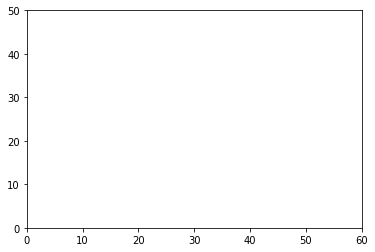

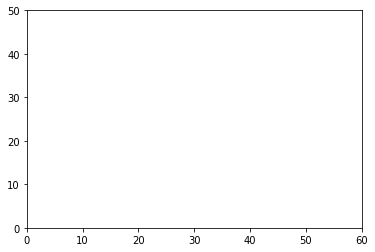

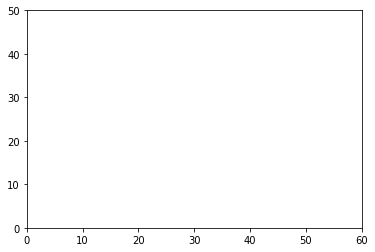

In [5]:
# Simulation time initialization.
T_MAX = 150
time_steps = np.arange(T_MAX)

# Initializing the robot's location.
x_0 = [30, 30, 0]

# The sequence of robot motions.
u = np.array([[3, 0, -3, 0], [0, 3, 0, -3]])
u_i = 1

# Robot sensor rotation command
w = np.multiply(0.3, np.ones(len(time_steps)))

# True map (note, columns of map correspond to y axis and rows to x axis, so 
# robot position x = x(1) and y = x(2) are reversed when plotted to match
M = 50
N = 60
true_map = np.zeros((M, N))
true_map[0:10, 0:10] = 1
true_map[30:35, 40:45] = 1
true_map[3:6,40:60] = 1;
true_map[20:30,25:29] = 1;
true_map[40:50,5:25] = 1;

# Initialize the belief map.
# We are assuming a uniform prior.
m = np.multiply(0.5, np.ones((M, N)))

# Initialize the log odds ratio.
L0 = np.log(np.divide(m, np.subtract(1, m)))
L = L0

# Parameters for the sensor model.
meas_phi = np.arange(-0.4, 0.4, 0.05)
rmax = 30 # Max beam range.
alpha = 1 # Width of an obstacle (distance about measurement to fill in).
beta = 0.05 # Angular width of a beam.

# Initialize the vector of states for our simulation.
x = np.zeros((3, len(time_steps)))
x[:, 0] = x_0
print("init successful")



# Intitialize figures.
map_fig = plt.figure()
map_ax = map_fig.add_subplot(111)
map_ax.set_xlim(0, N)
map_ax.set_ylim(0, M)

invmod_fig = plt.figure()
invmod_ax = invmod_fig.add_subplot(111)
invmod_ax.set_xlim(0, N)
invmod_ax.set_ylim(0, M)

belief_fig = plt.figure()
belief_ax = belief_fig.add_subplot(111)
belief_ax.set_xlim(0, N)
belief_ax.set_ylim(0, M)

meas_rs = []
meas_r = get_ranges(true_map, x[:, 0], meas_phi, rmax)
meas_rs.append(meas_r)
invmods = []
invmod = inverse_scanner(M, N, x[0, 0], x[1, 0], x[2, 0], meas_phi, meas_r, rmax, alpha, beta)
invmods.append(invmod)
ms = []
ms.append(m)

# Main simulation loop.
for t in range(1, len(time_steps)):
    # Perform robot motion.
    move = np.add(x[0:2, t-1], u[:, u_i]) 
    # If we hit the map boundaries, or a collision would occur, remain still.
    if (move[0] >= M - 1) or (move[1] >= N - 1) or (move[0] <= 0) or (move[1] <= 0) \
        or true_map[int(round(move[0])), int(round(move[1]))] == 1:
        x[:, t] = x[:, t-1]
        u_i = (u_i + 1) % 4
    else:
        x[0:2, t] = move
    x[2, t] = (x[2, t-1] + w[t]) % (2 * math.pi)
    
    # TODO Gather the measurement range data, which we will convert to occupancy probabilities
    # using our inverse measurement model.
    # meas_r = ...
    #added by me
    meas_r = get_ranges(true_map, x[:,t], meas_phi, rmax)
    meas_rs.append(meas_r)
    
    # TODO Given our range measurements and our robot location, apply our inverse scanner model
    # to get our measure probabilities of occupancy.
    # invmod = ...
    #added by me
    invmod = inverse_scanner(M, N, x[0, t], x[1, t], x[2, t], meas_phi, meas_r, rmax, alpha, beta)
    invmods.append(invmod)
    
    # TODO Calculate and update the log odds of our occupancy grid, given our measured
    # occupancy probabilities from the inverse model.
    # print(invmod)
     
    Lt = np.log(invmod/(1-invmod))
    L =  Lt - L0 + L
    # TODO Calculate a grid of probabilities from the log odds.
    Al = np.exp(L)
    m = (Al / (1 + Al))
    ms.append(m)
    



In [6]:
m_f = ms[-1]

print("{}".format(m_f[40, 10]))
print("{}".format(m_f[30, 40]))
print("{}".format(m_f[35, 40]))
print("{}".format(m_f[0, 50]))
print("{}".format(m_f[10, 5]))
print("{}".format(m_f[20, 15]))
print("{}".format(m_f[25, 50]))

0.985747800587
0.998863179956
0.844827586207
0.5
0.072972972973
0.000208997634687
1.2953015128e-06


In [8]:
def map_update(i):
    map_ax.clear()
    map_ax.set_xlim(0, N)
    map_ax.set_ylim(0, M)
    map_ax.imshow(np.subtract(1, true_map), cmap='gray', origin='lower', vmin=0.0, vmax=1.0)
    x_plot = x[1, :i+1]
    y_plot = x[0, :i+1]
    map_ax.plot(x_plot, y_plot, "bx-")

def invmod_update(i):
    invmod_ax.clear()
    invmod_ax.set_xlim(0, N)
    invmod_ax.set_ylim(0, M)
    invmod_ax.imshow(invmods[i], cmap='gray', origin='lower', vmin=0.0, vmax=1.0)
    for j in range(len(meas_rs[i])):
        invmod_ax.plot(x[1, i] + meas_rs[i][j] * math.sin(meas_phi[j] + x[2, i]), \
                       x[0, i] + meas_rs[i][j] * math.cos(meas_phi[j] + x[2, i]), "ko")
    invmod_ax.plot(x[1, i], x[0, i], 'bx')
    
def belief_update(i):
    belief_ax.clear()
    belief_ax.set_xlim(0, N)
    belief_ax.set_ylim(0, M)
    belief_ax.imshow(ms[i], cmap='gray', origin='lower', vmin=0.0, vmax=1.0)
    belief_ax.plot(x[1, max(0, i-10):i], x[0, max(0, i-10):i], 'bx-')
    
map_anim = anim.FuncAnimation(map_fig, map_update, frames=len(x[0, :]), repeat=False)
invmod_anim = anim.FuncAnimation(invmod_fig, invmod_update, frames=len(x[0, :]), repeat=False)
belief_anim = anim.FuncAnimation(belief_fig, belief_update, frames=len(x[0, :]), repeat=False)


HTML(map_anim.to_html5_video())

HTML(invmod_anim.to_html5_video())

HTML(belief_anim.to_html5_video())